In [1]:
import joblib, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, os
import numpy as np
from scipy.stats import rankdata
from copy import deepcopy
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

FIGEXT=".pdf"
sns.set('paper', font_scale=1.67)
np.random.seed(42)

#hyperparam_cols = ['what_coeff_mut','when_coeff_mut']#,'linear_scaling','data_standardization']
hyperparam_cols = ["Probability", "Strength", "Decay", "Patience", "Strategy"]

In [2]:
# Load dataset and some preproc
rdf = joblib.load("final_rdf.joblib")
rdf.reset_index(inplace=True, drop=True)
#rdf["what_coeff_mut"] = rdf["coeff_mut"].astype("str")
#rdf["what_coeff_mut"] = rdf["what_coeff_mut"].str.replace("_",",").replace("False","None")
#rdf["when_coeff_mut"] = rdf["gom_coeff_mut_strat"].astype('str')
#rdf["when_coeff_mut"] = np.where(rdf["coeff_mut"]==False, "Never", rdf["when_coeff_mut"])
#rdf["ims"] = rdf["ims"].astype("str")
#rdf.drop(["coeff_mut"], axis=1, inplace=True)

# transform into numerical versions
probs, strengths, decays, patiences = list(), list(), list(), list()
for i, row in rdf.iterrows():
  if row["coeff_mut"] == False:
    prob = 0
    strength = 0
    decay = -1
    patience = -1
  else:
    x = row["coeff_mut"].split("_")
    prob = x[0]
    strength = x[1] if x[1] != "es" else -1
    decay = -1 if x[1] == "es" else x[2]
    patience = -1 if x[1] == "es" else x[3]

  probs.append(prob)
  strengths.append(strength)
  decays.append(decay)
  patiences.append(patience)

rdf["Probability"] = pd.Series(probs).astype(float)
rdf["Strength"] = pd.Series(strengths).astype(float)
rdf["Decay"] = pd.Series(decays).astype(float)
rdf["Patience"] = pd.Series(patiences).astype(int)
rdf["Strategy"] = rdf["gom_coeff_mut_strat"].astype('str')
rdf["Strategy"] = np.where(rdf["coeff_mut"]==False, "Never", rdf["Strategy"])
rdf["Strategy"] = rdf["Strategy"].str.replace("afteronce","After GOM, once").replace("within","Within GOM step").replace("interleaved","In between GOM steps").replace("afterfossize","After GOM, $|F|$ times")

keijzer-1
burks
r1
keijzer-2
nguyen-7


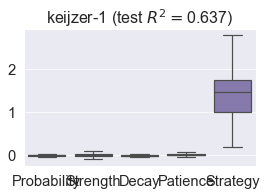

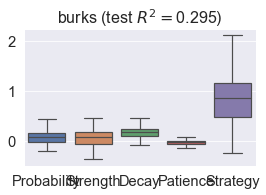

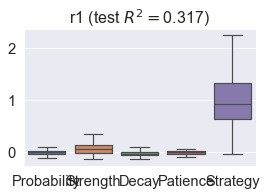

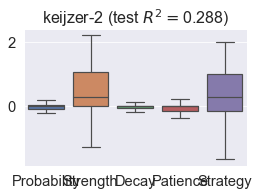

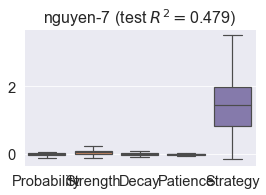

In [20]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance

param_grid = {
  'max_depth': [None,4],
  'min_samples_split':[2,4],
}

base_model = RF(random_state=42, max_features=None, n_estimators=500)
gs = GridSearchCV(base_model, param_grid, cv=5, refit=True, n_jobs=8)

def compute_hyperparam_importance(df, plot=True):
  dataset_name = df.dataset.unique()[0]
  print(dataset_name)
  categorical_encoder = OneHotEncoder(handle_unknown='ignore')
  preprocessing = ColumnTransformer(
      [
          ("cat", categorical_encoder, hyperparam_cols),
      ]
  )
  pipe = Pipeline(
      [
          ("preprocess", preprocessing),
          ("regressor", gs),
      ]
  )

  curr_df = df.groupby(hyperparam_cols).mean().reset_index()
  X = curr_df[hyperparam_cols]
  y = curr_df["train_rmse"]

  importances = list()
  rf_qualities = list()
  for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    pipe.fit(X_train, y_train)
    rf_quality = 1-mean_squared_error(y_test,pipe.predict(X_test))/np.var(y_train)
    rf_qualities.append(rf_quality)
    result = permutation_importance(
      pipe, X_test, y_test, n_repeats=10, random_state=i, n_jobs=8
    )
    importances.append(result.importances.T)

  if np.mean(rf_qualities) < .25:
    print("Low quality test acc on {} ({:.3f}), cannot trust it".format(dataset_name, np.mean(rf_qualities)))
    return

  if plot:
    fig, ax = plt.subplots(figsize=(4,3))
    temp_importances = np.concatenate(importances,axis=0)
    temp_importances = np.array(temp_importances).reshape((-1,len(hyperparam_cols)))
    imp_df = pd.DataFrame(temp_importances, columns=hyperparam_cols)
    sns.boxplot(data=imp_df, ax=ax, showfliers=False)
    ax.set_title("{} (test $R^2=${:.3f})".format(dataset_name, np.mean(rf_qualities)))
    plt.xticks(rotation = 45)
    fig.tight_layout()
    fig.savefig("plots/importance_{}{}".format(dataset_name,FIGEXT))


  return importances

if True:
  # known datasets where it works:
  dwiw = ["keijzer-1","burks","r1","keijzer-2","nguyen-7"]
  #importances = [compute_hyperparam_importance(rdf[rdf.dataset == d].copy()) for d in rdf.dataset.unique()]
  importances = [compute_hyperparam_importance(rdf[rdf.dataset == d].copy()) for d in dwiw]
  importances = [x for x in importances if x is not None]
  temp = list()
  for imp in importances:
    temp += imp
  importances = np.array(temp).reshape((-1,len(hyperparam_cols)))


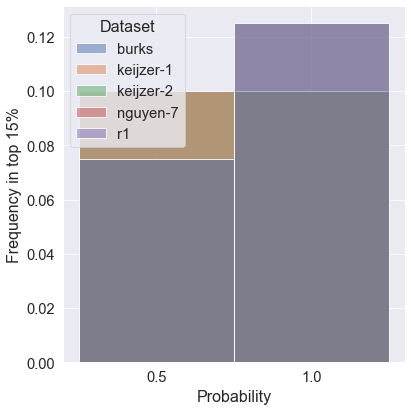

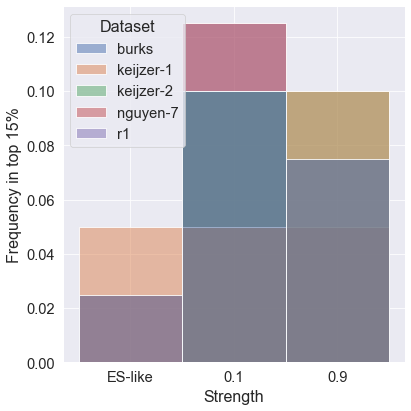

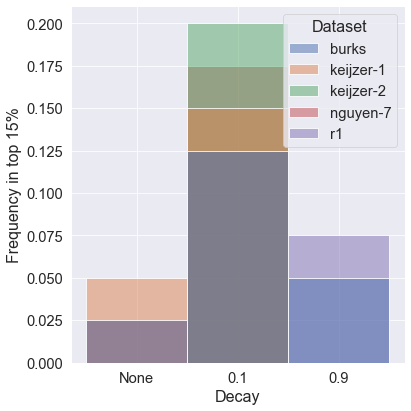

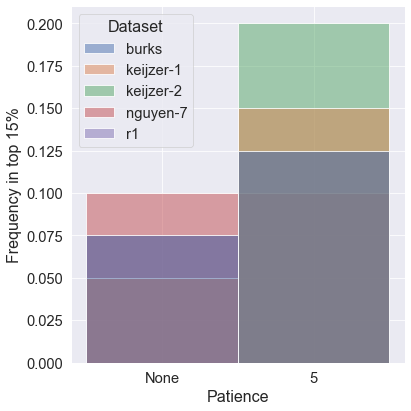

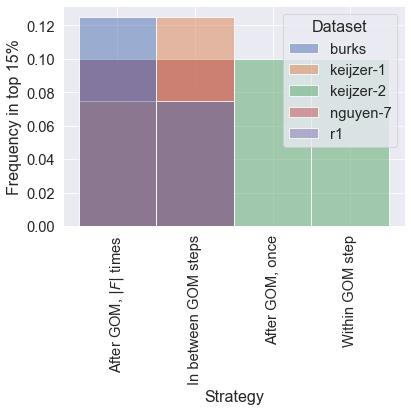

In [4]:
# zoom in into one data set
#for hp in ["Probability","Strategy"]:
#for dataset in ["keijzer-1", "keijzer-5","korns-4", "r1"]:
df = rdf.copy() #[rdf.dataset == dataset].copy()
#df = df.groupby(hyperparam_cols).mean().reset_index()
#df["Probability"] = df["Probability"].astype("str")
# what config is the most successful?


# for each param conf & dataset, get top 25% median train_rmse
heads = list()
for d in df.dataset.unique():
  cdf = df[df.dataset==d].copy()
  cdf = cdf.groupby(hyperparam_cols).median().reset_index().sort_values(by="train_rmse")
  cdf["dataset"] = d
  head = cdf.head(int(len(cdf)*0.15))
  heads.append(head)
  
"""
df = df.groupby(hyperparam_cols+["dataset"]).median().reset_index()
df.sort_values(by="train_rmse", inplace=True)
l = len(df)
head = df[hyperparam_cols+["dataset"]].groupby("dataset").head(int(0.1*l)).reset_index(drop=True)
for d in head.dataset.unique():
  print(head[head.dataset==d])
asd
"""
head = pd.concat(heads).reset_index(drop=True)

datasets_to_consider = list(np.unique([x.split("_")[1].split(".")[0] for x in os.listdir("plots") if x.startswith("importance")]))
head = head[head.dataset.isin(datasets_to_consider)]
head["Dataset"] = head["dataset"]
head.drop("dataset",axis=1,inplace=True)

#head.sort_values(by="train_rmse", inplace=True)
for hp in hyperparam_cols:
  fig, ax = plt.subplots(figsize=(6,6))
  head.sort_values(by=["Dataset",hp], inplace=True)
  head[hp] = head[hp].astype('str')
  if hp == "Strength":
    head[hp] = np.where(head[hp]=="-1.0", "ES-like", head[hp])
  elif hp == "Patience":
    head[hp] = np.where(head[hp]=="-1","None", head[hp])
  else:
    head[hp] = np.where(head[hp]=="-1.0", "None", head[hp])

  g = sns.histplot(data=head, x=hp, hue="Dataset", stat='probability', ax=ax)
  ax.set_ylabel("Frequency in top 15%")
  #ax.set_title(dataset)
  if hp == "Strategy":
    plt.xticks(rotation = 90)
  fig.tight_layout()
  fig.savefig("plots/top_performing_{}{}".format(hp,FIGEXT))

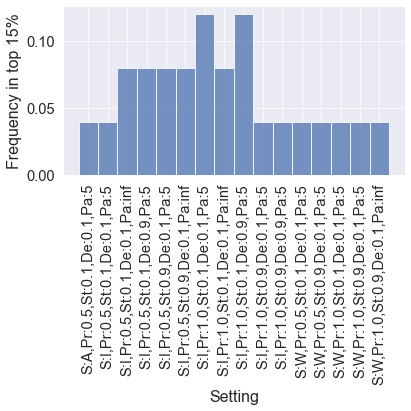

In [5]:
# joint
df = rdf.copy() 

# for each param conf & dataset, get top median train_rmse
heads = list()
for d in df.dataset.unique():
  cdf = df[df.dataset==d].copy()
  cdf["Setting"] = "S:"+cdf["Strategy"].str[0:1]+",Pr:" + cdf["Probability"].astype('str') + ",St:" +cdf["Strength"].astype('str') + ",De:" + cdf["Decay"].astype('str') + ",Pa:" +cdf["Patience"].astype('str')
  # some replacements
  cdf.loc[cdf["Setting"].str.startswith("Pr:-1"),"Setting"] = "No coeff. mut."
  cdf.loc[cdf["Setting"].str.contains("St:-1"),"Setting"] = "Pr:" + cdf["Probability"].astype('str') + ",ES-like"
  cdf["Setting"] = cdf["Setting"].str.replace("Pa:-1","Pa:inf")
  cdf["Setting"] = cdf["Setting"].str.replace("Pa:-1","Pa:inf")
  cdf = cdf.groupby("Setting").median().reset_index().sort_values(by="train_rmse")
  cdf["Dataset"] = d
  head = cdf.head(int(len(cdf)*0.15))
  heads.append(head)
  
"""
df = df.groupby(hyperparam_cols+["dataset"]).median().reset_index()
df.sort_values(by="train_rmse", inplace=True)
l = len(df)
head = df[hyperparam_cols+["dataset"]].groupby("dataset").head(int(0.1*l)).reset_index(drop=True)
for d in head.dataset.unique():
  print(head[head.dataset==d])
asd
"""
head = pd.concat(heads).reset_index(drop=True)

datasets_to_consider = list(np.unique([x.split("_")[1].split(".")[0] for x in os.listdir("plots") if x.startswith("importance")]))
head = head[head.Dataset.isin(datasets_to_consider)]

#head.sort_values(by="train_rmse", inplace=True)
fig, ax = plt.subplots(figsize=(6,6))
head.sort_values(by=["Setting"], inplace=True)

#if hp == "Strength":
#  head[hp] = np.where(head[hp]=="-1.0", "ES-like", head[hp])
#elif hp == "Patience":
#  head[hp] = np.where(head[hp]=="-1","None", head[hp])
#else:
#  head[hp] = np.where(head[hp]=="-1.0", "None", head[hp])

sns.histplot(data=head, x="Setting", stat='probability', ax=ax)
#ax.set_title(dataset)
ax.set_ylabel("Frequency in top 15%")
plt.xticks(rotation = 90)
fig.tight_layout()
fig.savefig("plots/top_performing_joint_{}".format(FIGEXT))

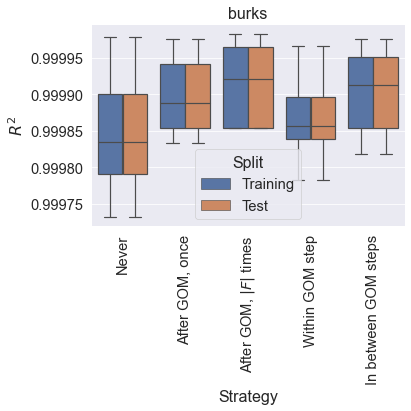

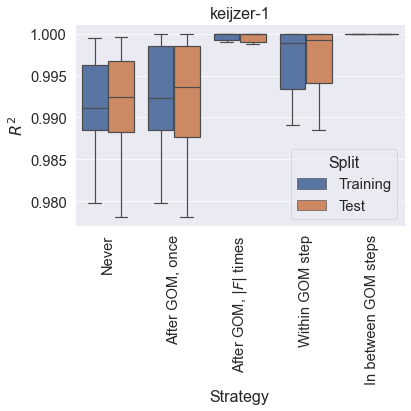

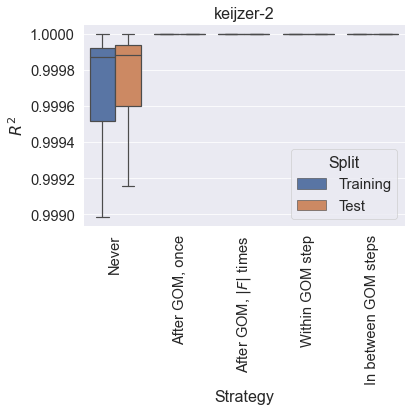

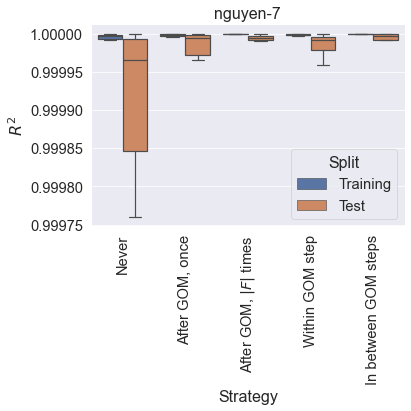

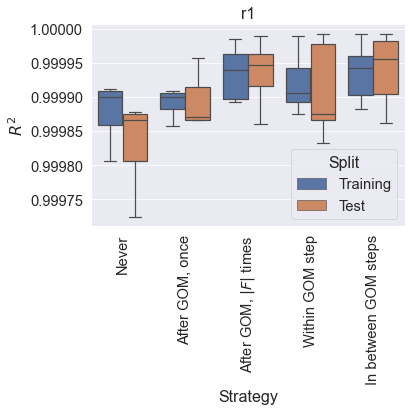

In [6]:
# partition per strategy
strat_sort = ['Never', 'After GOM, once', 'After GOM, $|F|$ times', 'Within GOM step', 'In between GOM steps']
for dataset in datasets_to_consider:
  df = rdf[rdf.dataset == dataset].copy()
  # subselect 1.0_0.1_0.1_5 based on findings above
  df = df[(df.Probability==1.0)&(df.Strength==0.1)&(df.Decay==0.1)&(df.Patience==5)|
    (df.Strategy=="Never")]
  # sort
  df.Strategy = df.Strategy.astype("category")
  df.Strategy = df.Strategy.cat.set_categories(strat_sort)
  df.sort_values(["Strategy"], inplace=True)
  # rearrange info a bit
  df["$R^2$"] = df["train_r2"]
  df["Split"] = "Training"
  df2 = df.copy()
  df2["$R^2$"] = df["test_r2"]
  df2["Split"] = "Test"
  df = pd.concat((df,df2))
  # plot
  fig, ax = plt.subplots(figsize=(6,6))
  g = sns.boxplot(data=df, x="Strategy", y="$R^2$", hue="Split", ax=ax, showfliers=False)
  ax.set_title(dataset)
  plt.xticks(rotation = 90)
  fig.tight_layout()
  fig.savefig("plots/r2_{}{}".format(dataset,FIGEXT))

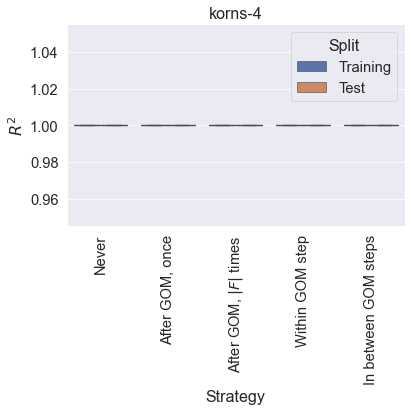

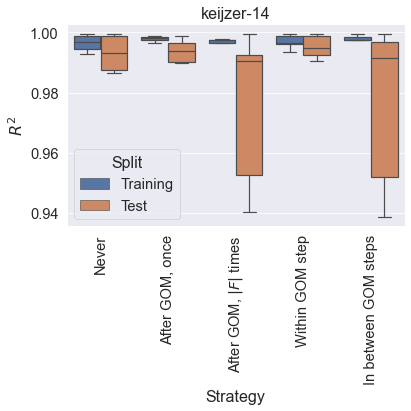

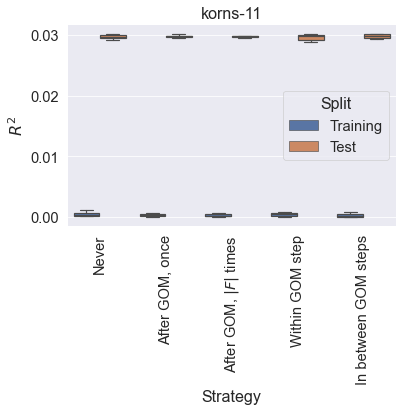

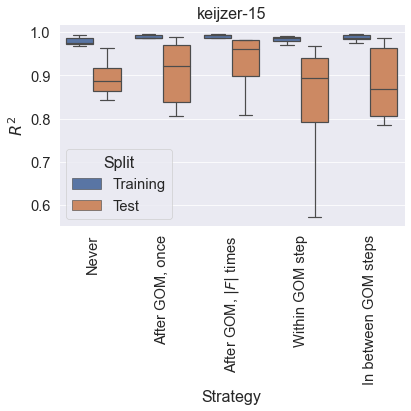

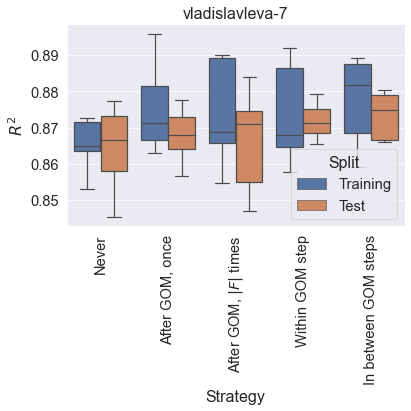

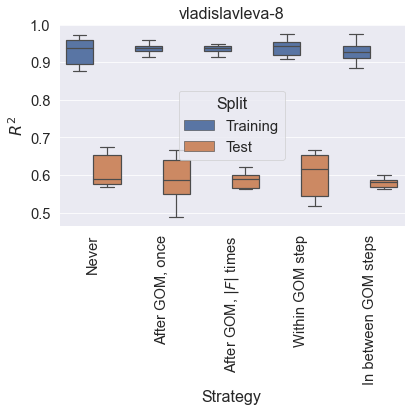

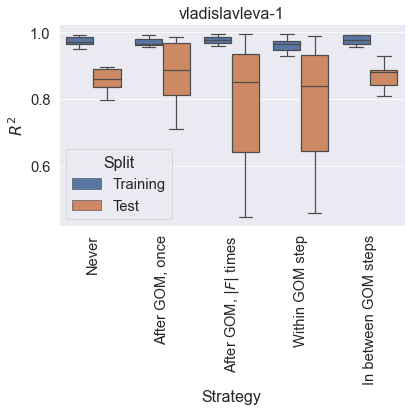

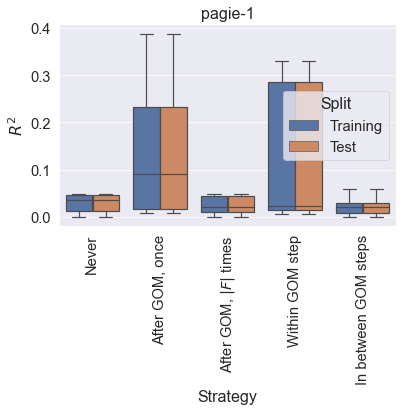

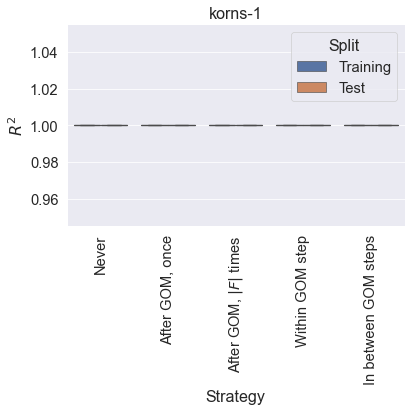

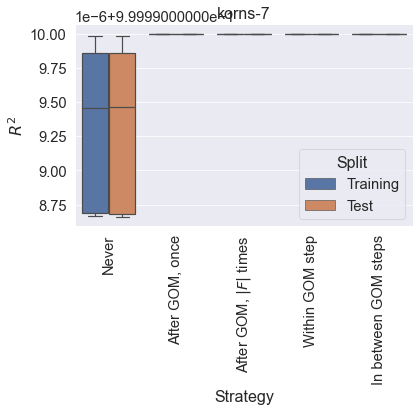

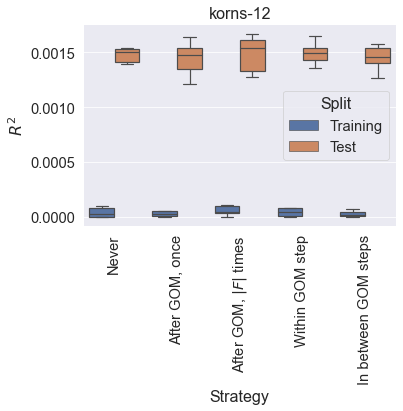

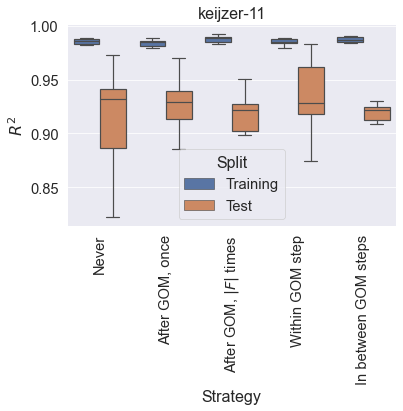

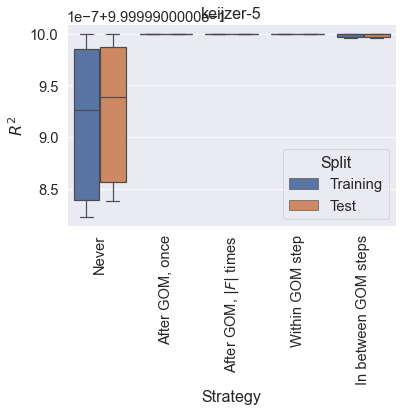

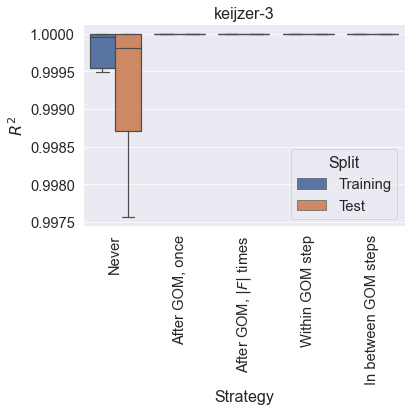

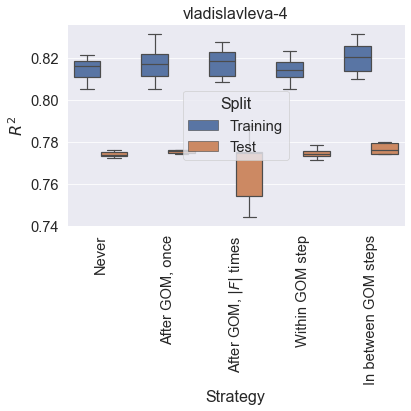

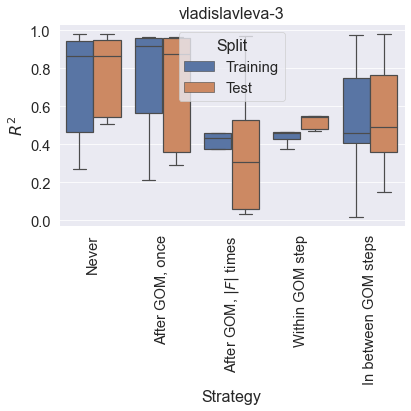

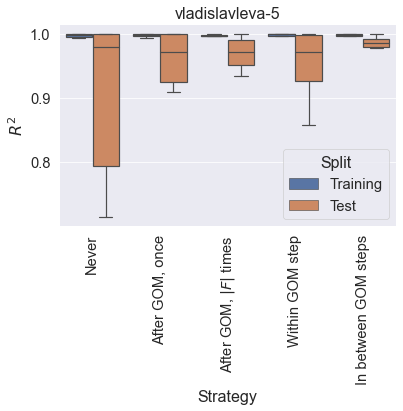

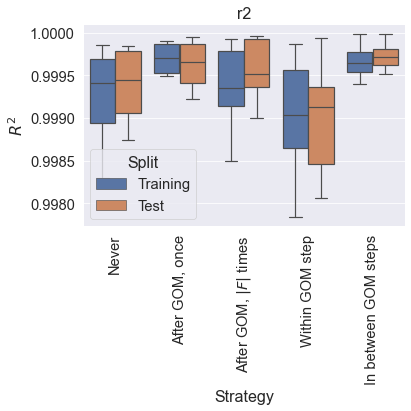

In [7]:
# same as before but on 4 random data sets where we did not make it
other_datasets = [x for x in rdf.dataset.unique() if x not in datasets_to_consider]
for dataset in other_datasets:
  df = rdf[rdf.dataset == dataset].copy()
  df = df[(df.Probability==1.0)&(df.Strength==0.1)&(df.Decay==0.1)&(df.Patience==5)|
    (df.Strategy=="Never")]
  # sort
  df.Strategy = df.Strategy.astype("category")
  df.Strategy = df.Strategy.cat.set_categories(strat_sort)
  df.sort_values(["Strategy"], inplace=True)
  # rearrange info a bit
  df["$R^2$"] = df["train_r2"]
  df["Split"] = "Training"
  df2 = df.copy()
  df2["$R^2$"] = df["test_r2"]
  df2["Split"] = "Test"
  df = pd.concat((df,df2))
  # plot
  fig, ax = plt.subplots(figsize=(6,6))
  g = sns.boxplot(data=df, x="Strategy", y="$R^2$", hue="Split", ax=ax, showfliers=False)
  ax.set_title(dataset)
  plt.xticks(rotation = 90)
  fig.tight_layout()
  fig.savefig("plots/r2_{}{}".format(dataset,FIGEXT))

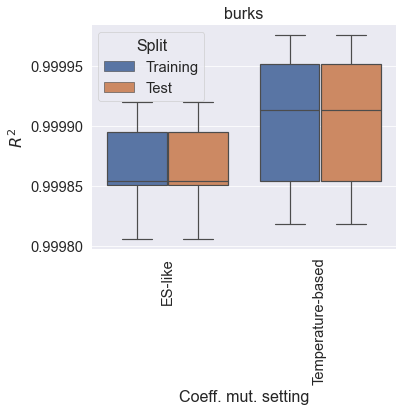

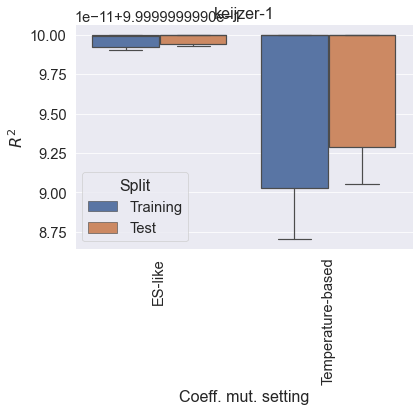

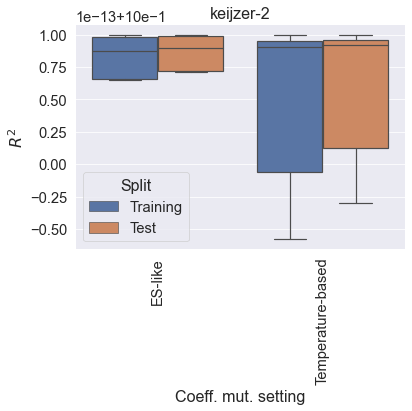

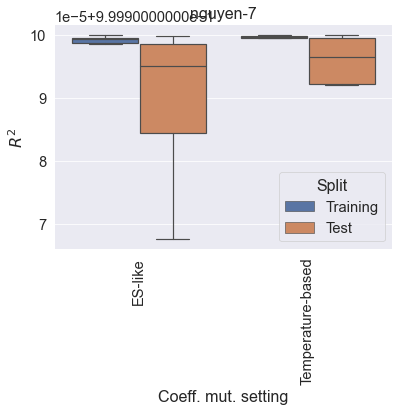

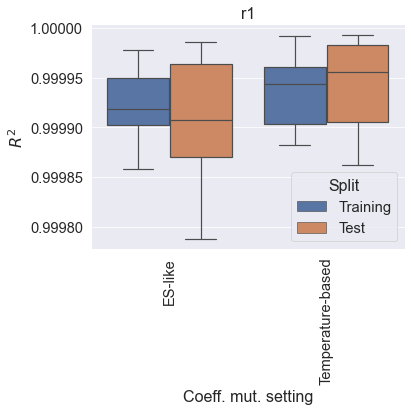

In [8]:
# keep In between gom steps but see ES vs best other
col_name = "Coeff. mut. setting"
for dataset in datasets_to_consider:
  df = rdf[(rdf.dataset == dataset)&(rdf.Strategy=="In between GOM steps")].copy()

  df[col_name] = "xxx"
  df.loc[(df.Probability==1.0)&(df.Strength==0.1)&(df.Decay==0.1)&(df.Patience==5),col_name] = "Temperature-based"
  df.loc[(df.Probability==1.0)&(df.Strength==-1), col_name] = "ES-like"
  df.loc[(df.Probability==0.0), col_name] = "None"
  df = df[df[col_name]!="xxx"]
  # sort
  df.sort_values([col_name], inplace=True)
  # rearrange info a bit
  df["$R^2$"] = df["train_r2"]
  df["Split"] = "Training"
  df2 = df.copy()
  df2["$R^2$"] = df["test_r2"]
  df2["Split"] = "Test"
  df = pd.concat((df,df2))
  # plot
  fig, ax = plt.subplots(figsize=(6,6))
  g = sns.boxplot(data=df, x=col_name, y="$R^2$", hue="Split", ax=ax, showfliers=False)
  ax.set_title(dataset)
  plt.xticks(rotation = 90)
  fig.tight_layout()
  fig.savefig("plots/r2_cmtype_{}{}".format(dataset,FIGEXT))